## Wearable Tech: Week 3 Assignment

In [1]:
#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
import matplotlib.dates as mdates

from datetime import datetime
import plotly.graph_objects as go

df = pd.read_csv("../Data/WBBtotal.csv", index_col =["Timestamp"], parse_dates=["Timestamp"])
df

,Seconds,Velocity,Acceleration,Odometer,Latitude,Longitude,Heart Rate,Player Load,AthleteID
Timestamp,,,,,,,,,
2019-01-08 17:39:42,0.0,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.1,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.2,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.3,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.4,0,0,0,0,0,83,0.0,Athlete 1
...,...,...,...,...,...,...,...,...,...
2019-03-08 16:47:03,11484.4,0,0,0,0,0,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.5,0,0,0,0,0,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.6,0,0,0,0,0,101,1001.5,Athlete 5


### Initial data preparation
The dataset is generated by the Catapult device which collects a host of data, including gps derived metrics. Basketball being played indoors, those metrics are not relevant for our analysis of relative intensity. Therefore I will select only the target metrics.

In [3]:
target_cols = ['Seconds','Heart Rate', 'Player Load', 'AthleteID']

df_hr = df[target_cols]
df_hr

,Seconds,Heart Rate,Player Load,AthleteID
Timestamp,,,,
2019-01-08 17:39:42,0.0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.1,83,0.0,Athlete 1
2019-01-08 17:39:42,0.2,83,0.0,Athlete 1
2019-01-08 17:39:42,0.3,83,0.0,Athlete 1
2019-01-08 17:39:42,0.4,83,0.0,Athlete 1
...,...,...,...,...
2019-03-08 16:47:03,11484.4,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.5,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.6,101,1001.5,Athlete 5


Likewise, in the assignment we were instructed to focus only in the data belonging to March 9, 2019.

In [4]:
df_20190309 = df_hr.loc['2019-03-09']
df_20190309


,Seconds,Heart Rate,Player Load,AthleteID
Timestamp,,,,
2019-03-09 15:57:49,0.0,0,0.0,Athlete 10
2019-03-09 15:57:49,0.1,0,0.0,Athlete 10
2019-03-09 15:57:49,0.2,0,0.0,Athlete 10
2019-03-09 15:57:49,0.3,0,0.0,Athlete 10
2019-03-09 15:57:49,0.4,0,0.0,Athlete 10
...,...,...,...,...
2019-03-09 19:08:14,11348.4,108,470.6,Athlete 8
2019-03-09 19:08:14,11348.5,106,470.6,Athlete 8
2019-03-09 19:08:14,11348.6,106,470.6,Athlete 8


Given that the final aim of the exercise was the calculation of TRIMP scores, high quality HR data was very important. Therefore, it's concerning to observe the high number of rows with a HR value of zero (which is obviously impossible).

In [9]:
df_20190309.loc[df_20190309["Heart Rate"] == 0, "Heart Rate"].count()

69452

### Data cleanup
As stated, it's problematic to have zero values for heart rate, so I'll go and remove them (ie. make them NaN).

In [21]:
df_20190309.loc[df_20190309['Heart Rate'] ==0, 'Heart Rate'] = np.nan

We have only do this for the column *Heart Rate*. Therefore, it's possible to know the percentage of the heart rate values that were zero for each player:
* Get the number of zero values. That is the difference between the number of Training Load and Heart Rate. 
* Get the proportion. Once the number of zero values for HR are known. It's just a matter of dividing it by the total number to get the proportion. 
As seen, it's typical to have around 5% of heart rate data removed.

In [27]:
data_summary = df_20190309.groupby('AthleteID')['Heart Rate','Player Load'].count()
data_summary["missing_hr"] = data_summary["Player Load"] - data_summary["Heart Rate"]
data_summary["missing_hr_percentage"] = data_summary["missing_hr"]/data_summary["Player Load"]*100
data_summary

,Heart Rate,Player Load,missing_hr,missing_hr_percentage
AthleteID,,,,
Athlete 1,110378,113379,3001,2.646875
Athlete 10,104229,114261,10032,8.779899
Athlete 11,105176,113469,8293,7.308604
Athlete 12,109057,113689,4632,4.074273
Athlete 13,105498,113346,7848,6.923932
Athlete 2,109071,113829,4758,4.179954
Athlete 3,106787,113519,6732,5.930285
Athlete 4,110829,113749,2920,2.567056
Athlete 5,108154,113629,5475,4.818312


### Plotting HR values
In order to illustrate the different HR reactions among players, I plotted the heart rate for the March 9 game for the players with the highest and the lowest training load. In our case, players 10 and 6 respectively.



In [31]:
player_load_rankings = df_20190309.groupby("AthleteID")["Player Load"].max().sort_values(ascending = False)
player_load_rankings

AthleteID
Athlete 10    1038.8
Athlete 1      919.4
Athlete 7      904.5
Athlete 9      890.8
Athlete 5      790.5
Athlete 2      549.3
Athlete 8      470.6
Athlete 4      422.6
Athlete 12     355.9
Athlete 13     344.8
Athlete 11     342.1
Athlete 3      337.3
Athlete 6      265.9
Name: Player Load, dtype: float64

AthleteID
Athlete 10    AxesSubplot(0.125,0.125;0.775x0.755)
Athlete 6     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

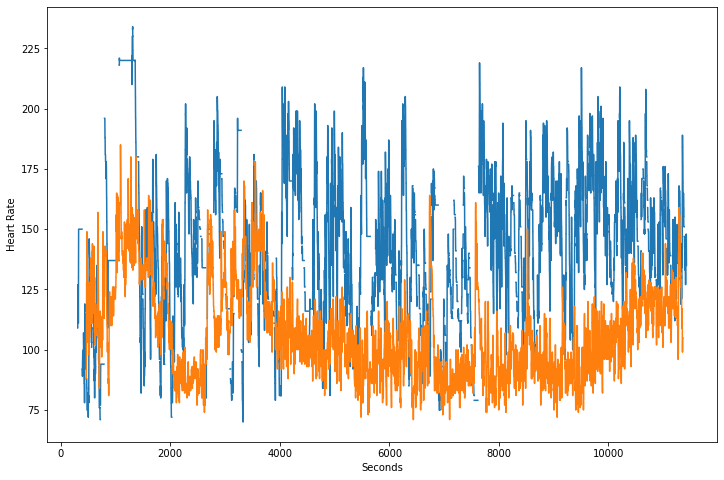

In [35]:
(df_20190309.query("AthleteID == 'Athlete 10' or AthleteID == 'Athlete 6'")
    .groupby("AthleteID")
    .plot(x="Seconds",y="Heart Rate", ax=plt.gca(), ylabel="Heart Rate", figsize=(12,8), legend=False))

### Calculating TRIMP values
In this case, these TRIMP calculations are going to be gross oversimplification. We assume that all the players on the team have the same values of max and resting heart rate. Also, it is assumed that all players played the same amount of time...

Reading from the assignment:

*The calculation is as follows:*

*TRIMP = t * k * FHRR (Expressed as an arbitrary unit)*

*t=minutes of the bout of exercise*

*k = a constant based on sex of the athlete*

*FHRR is the fraction of the heart rate reserve that they had during the session. This is calculated as the (HR avg - HR rest) / (HR max - HR rest)*

*So we have the minutes of exercise in the session (based on what was recorded by Catapult) and we have the mean HR across the period. So we have what we need to calculate the TRIMP value.*

In [37]:
average_hr_by_player = df_20190309.groupby("AthleteID")[["Heart Rate"]].mean()
average_hr_by_player

,Heart Rate
AthleteID,
Athlete 1,143.249696
Athlete 10,143.739545
Athlete 11,108.726088
Athlete 12,90.120524
Athlete 13,109.495981
Athlete 2,120.254834
Athlete 3,93.868420
Athlete 4,84.351072
Athlete 5,132.837472


In [39]:
t= 12000/60  # 12000 seconds divided by 60 to provide minutes (200 minutes in this double-overtime game with warm-up time included)

HRmax=200
HRrest=60

FHRR = (average_hr_by_player['Heart Rate']-HRrest)/ (HRmax-HRrest)
FHRR

AthleteID
Athlete 1     0.594641
Athlete 10    0.598140
Athlete 11    0.348043
Athlete 12    0.215147
Athlete 13    0.353543
Athlete 2     0.430392
Athlete 3     0.241917
Athlete 4     0.173936
Athlete 5     0.520268
Athlete 6     0.341227
Athlete 7     0.576337
Athlete 8     0.379566
Athlete 9     0.595872
Name: Heart Rate, dtype: float64

In [41]:
kval = (np.exp(1.67 * FHRR))

TRIMP = t * FHRR * kval
TRIMP.sort_values(ascending = False)

AthleteID
Athlete 10    324.822671
Athlete 9     322.367890
Athlete 1     321.041173
Athlete 7     301.791750
Athlete 5     248.080302
Athlete 2     176.621997
Athlete 8     143.089162
Athlete 13    127.610514
Athlete 11    124.477146
Athlete 6     120.657609
Athlete 3      72.469069
Athlete 12     61.631714
Athlete 4      46.512651
Name: Heart Rate, dtype: float64